Sử dụng thiết bị: cuda

--- BƯỚC 1: LOAD VÀ TIỀN XỬ LÝ DỮ LIỆU (Fill Median + StandardScaler) ---
Using 998195 training samples.
Read 200000 test samples with 46 features.
Unique labels in test set: [0 1]
Tiền xử lý dữ liệu thô (StandardScaler) hoàn tất.

--- BƯỚC 2: HUẤN LUYỆN MODEL GIẢM CHIỀU (AdvancedDimReducerAE) ---
Input dimension: 46D
Bắt đầu huấn luyện model 'AdvancedDimReducerAE' với loss 'MSELoss'...
Epoch 10/100 | Train Loss: 0.011904 | Val Loss: 0.541860 | LR: 5.00e-04
Epoch 20/100 | Train Loss: 0.005660 | Val Loss: 0.231476 | LR: 5.00e-04
Epoch 30/100 | Train Loss: 0.005197 | Val Loss: 0.077695 | LR: 5.00e-04
Early stopping được kích hoạt tại epoch 38.
Huấn luyện hoàn tất trong 183.71 giây. Best Val Loss: 0.070073. Model tốt nhất đã lưu vào 'best_dim_reducer_ae.pth'.

--- BƯỚC 3: TẠO DỮ LIỆU TRONG KHÔNG GIAN TIỀM ẨN (LATENT SPACE) ---
Đã giảm chiều dữ liệu từ 46D xuống 32D.

--- BƯỚC 4: TIỀN XỬ LÝ DỮ LIỆU (LATENT) ---
Tiền xử lý dữ liệu latent (StandardScaler) hoàn tất.

-

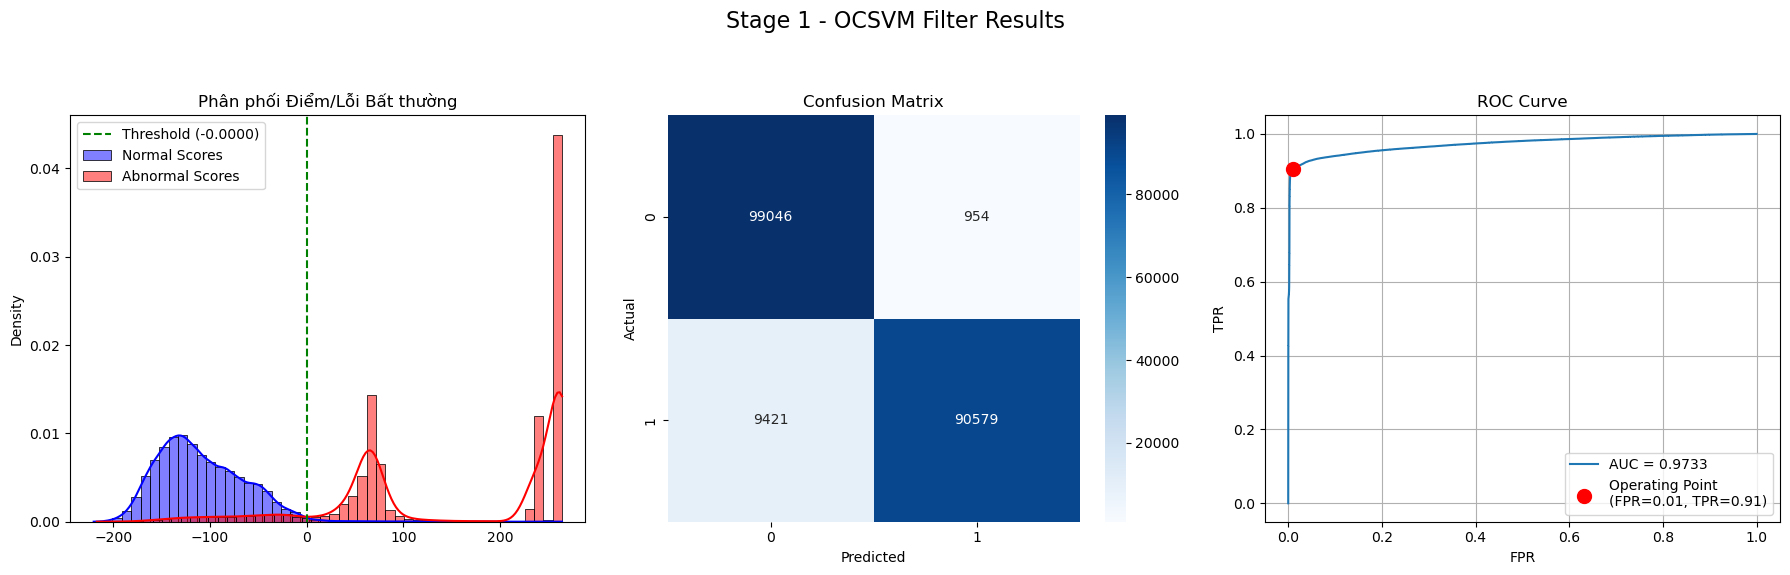


==================== BƯỚC 8: ĐÁNH GIÁ (STAGE 2 - PIPELINE) ====================
Thực hiện pipeline: Các mẫu OCSVM dự đoán là Normal (0) sẽ được Deep AE dự đoán lại...
OCSVM (Stage 1) phát hiện 91533 mẫu bất thường.
Đưa 108467 mẫu 'Normal' vào Deep AE (Stage 2) để kiểm tra lại...

--- Đang vẽ biểu đồ cho: Stage 2 - Deep AE on OCSVM-Normals ---
AUC: 0.8172 | F1-Score: 0.3619
Precision: 0.5533 | Recall (TPR): 0.2689
FPR: 0.0206 | FNR: 0.7311
TP: 2533 | FP: 2045 | TN: 97001 | FN: 6888


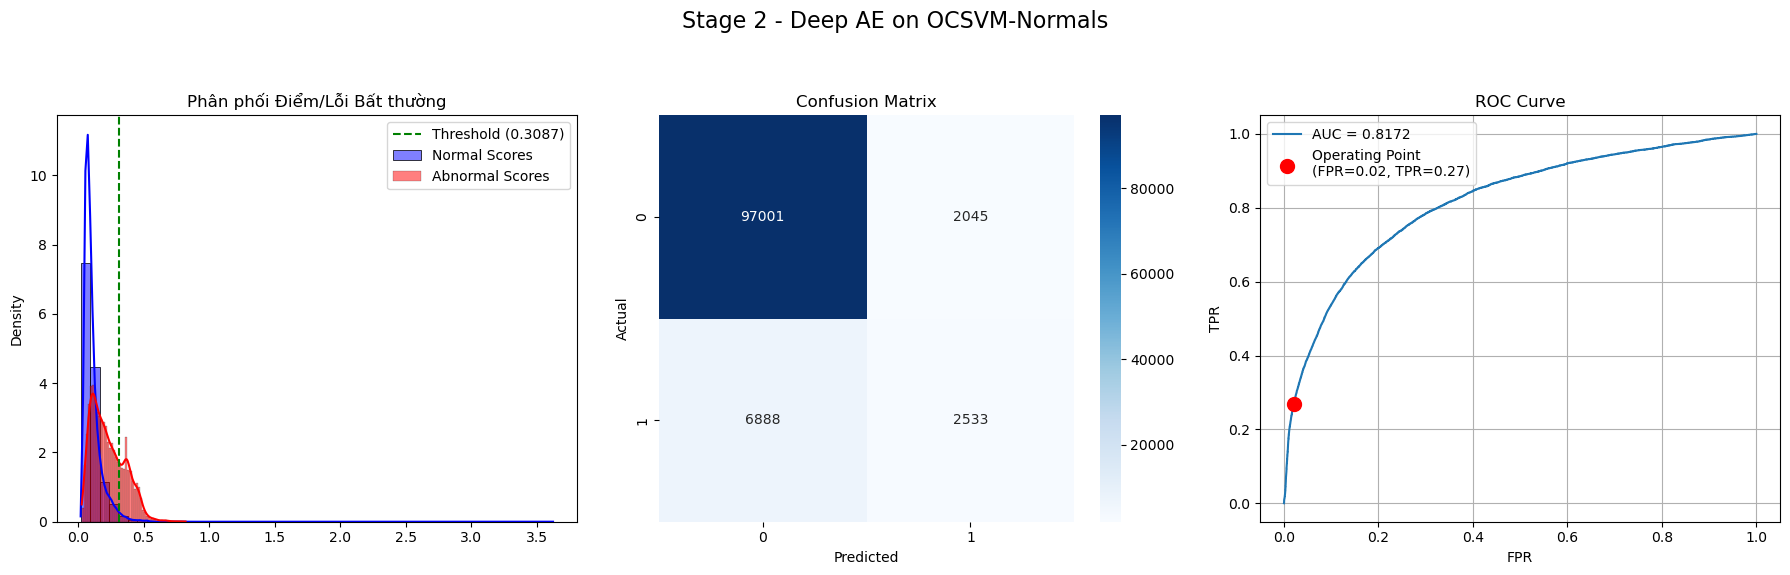


==================== BƯỚC 9: KẾT QUẢ CUỐI CÙNG (COMBINED) ====================
Các chỉ số cuối cùng của toàn bộ pipeline (OCSVM -> Deep AE):
Accuracy: 0.9506
Precision: 0.9688
Recall (TPR): 0.9311
F1-Score: 0.9496
False Positive Rate (FPR): 0.0300
False Negative Rate (FNR): 0.0689
TP: 93112 | FP: 2999 | TN: 97001 | FN: 6888



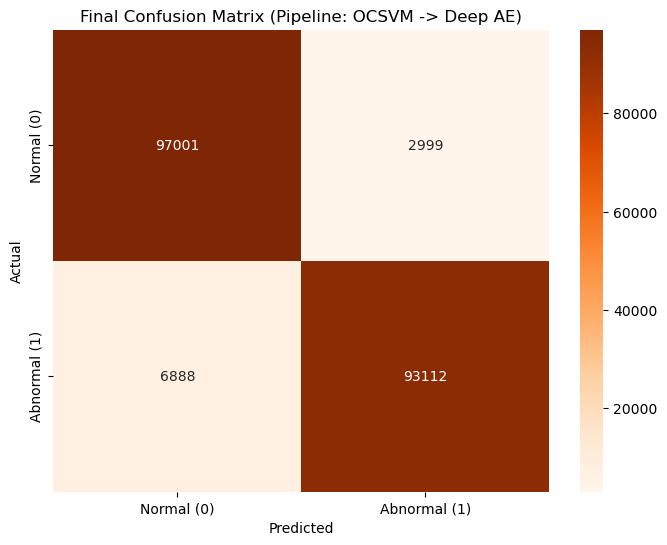

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler # <<< Quay lại StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import warnings

warnings.filterwarnings('ignore')

# Thiết lập thiết bị tính toán (GPU nếu có)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {DEVICE}\n")

# ===================================================================
# CÁC LỚP MODEL (Deep AE Enhanced Capacity)
# ===================================================================

class AdvancedDimReducerAE(nn.Module):
    """
    Model 1: Giảm chiều dữ liệu (46D -> 32D). Input -> 128 -> 64 -> 32.
    """
    def __init__(self, input_dim, latent_dim=32):
        super(AdvancedDimReducerAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z

class DeepAnomalyAE(nn.Module):
    """
    Model 2: Phát hiện bất thường (Kiến trúc robust 32D -> 8D).
    Increased layer width (capacity), tight bottleneck, increased dropout.
    """
    def __init__(self, input_dim=32, latent_dim=8): # <<< Bottleneck 8D
        super(DeepAnomalyAE, self).__init__()
        # Input (32) -> 256 -> 128 -> 8 (Latent)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),      # <<< Increased width
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),                # <<< Increased dropout
            nn.Linear(256, 128),      # <<< Increased width
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),                # <<< Increased dropout
            nn.Linear(128, latent_dim) # To 8
        )
        # 8 (Latent) -> 128 -> 256 -> 32 (Output)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),      # <<< Increased width
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),                # <<< Increased dropout
            nn.Linear(128, 256),      # <<< Increased width
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),                # <<< Increased dropout
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

# ===================================================================
# HÀM HUẤN LUYỆN (Optimized)
# ===================================================================

def train_model(model, train_loader, val_loader, epochs, patience, learning_rate, weight_decay, model_save_path, loss_fn):
    model.to(DEVICE)
    criterion = loss_fn
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Adam optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8) # Increased patience

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Bắt đầu huấn luyện model '{model.__class__.__name__}' với loss '{criterion.__class__.__name__}'...")
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        for (data,) in train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            reconstructed = output[0] if isinstance(output, tuple) else output
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * data.size(0)

        avg_epoch_train_loss = epoch_train_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for (data,) in val_loader:
                data = data.to(DEVICE)
                output = model(data)
                reconstructed = output[0] if isinstance(output, tuple) else output
                loss = criterion(reconstructed, data)
                val_loss += loss.item() * data.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0
        scheduler.step(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_epoch_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        if avg_val_loss < best_val_loss - 1e-6:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping được kích hoạt tại epoch {epoch+1}.")
            break

    end_time = time.time()
    best_loss_str = f"{best_val_loss:.6f}" if best_val_loss != float('inf') else "N/A"
    print(f"Huấn luyện hoàn tất trong {end_time - start_time:.2f} giây. Best Val Loss: {best_loss_str}. Model tốt nhất đã lưu vào '{model_save_path}'.\n")
    try:
        model.load_state_dict(torch.load(model_save_path))
    except FileNotFoundError: print(f"Warning: Could not load {model_save_path}.")
    except Exception as e: print(f"Warning: Error loading {model_save_path}: {e}.")
    return model


# ===================================================================
# HÀM HỖ TRỢ ĐÁNH GIÁ & TRỰC QUAN HÓA (More Robust)
# ===================================================================

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        unique_preds=np.unique(y_pred); unique_true=np.unique(y_true); tn,fp,fn,tp=0,0,0,0
        if len(unique_true)==1:
            if unique_true[0]==0: tn=len(y_true);
            else: tp=len(y_true);
        elif len(unique_preds)==1:
             if unique_preds[0]==0: tn=np.sum(y_true==0); fn=np.sum(y_true==1);
             else: fp=np.sum(y_true==0); tp=np.sum(y_true==1);
        print("Warning: CM calculation issue.")
    fpr = fp/(fp+tn) if (fp+tn)>0 else 0.0
    fnr = fn/(fn+tp) if (fn+tp)>0 else 0.0
    return accuracy, precision, recall, f1, fpr, fnr, (tn, fp, fn, tp)

def plot_evaluation(y_true, scores, y_pred, threshold, title):
    print(f"\n--- Đang vẽ biểu đồ cho: {title} ---")
    auc = 0.5
    try:
        y_true=np.asarray(y_true).astype(int); scores=np.asarray(scores); y_pred=np.asarray(y_pred).astype(int);
        if not np.issubdtype(scores.dtype, np.number): raise TypeError("scores non-numeric")
        scores=np.nan_to_num(scores, nan=np.nanmedian(scores), posinf=np.nanmax(scores[np.isfinite(scores)]), neginf=np.nanmin(scores[np.isfinite(scores)]))
        if not np.all(np.isfinite(scores)): raise ValueError("Non-finite scores remain")
        unique_labels_true = np.unique(y_true)
        if len(unique_labels_true)<2: print(f"Warning: Only one class ({unique_labels_true}). Cannot calc AUC.")
        else: auc=roc_auc_score(y_true, scores)
    except ValueError as e: print(f"Warning: Cannot calc AUC. Error: {e}")
    except TypeError as e: print(f"Error calc AUC: {e}")

    accuracy, precision, recall, f1, fpr, fnr, (tn, fp, fn, tp) = calculate_metrics(y_true, y_pred)
    print(f"AUC: {auc:.4f} | F1-Score: {f1:.4f}"); print(f"Precision: {precision:.4f} | Recall (TPR): {recall:.4f}"); print(f"FPR: {fpr:.4f} | FNR: {fnr:.4f}"); print(f"TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}")
    plt.figure(figsize=(18, 6)); plt.suptitle(title, fontsize=16); plt.subplot(1, 3, 1)
    unique_labels_plot = np.unique(y_true)
    if len(unique_labels_plot) > 1:
        if 0 in unique_labels_plot: sns.histplot(scores[y_true==0], color='blue', label='Normal Scores', kde=True, bins=50, stat="density")
        if 1 in unique_labels_plot: sns.histplot(scores[y_true==1], color='red', label='Abnormal Scores', kde=True, bins=50, stat="density")
    elif len(unique_labels_plot) == 1: label_text = 'Normal' if unique_labels_plot[0] == 0 else 'Abnormal'; sns.histplot(scores, color='purple', label=f'{label_text} Scores Only', kde=True, bins=50, stat="density")
    else: plt.text(0.5, 0.5, 'No data', ha='center')
    plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.4f})'); plt.title('Phân phối Điểm/Lỗi Bất thường'); plt.legend(); plt.subplot(1, 3, 2)
    labels_cm = sorted(np.unique(y_true))
    if not np.all(np.isin(np.unique(y_pred), labels_cm)): print(f"Warning: Predictions contain labels not in y_true.")
    cm = confusion_matrix(y_true, y_pred, labels=labels_cm); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'{l}' for l in labels_cm], yticklabels=[f'{l}' for l in labels_cm]); plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.subplot(1, 3, 3)
    if auc > 0.5 and len(unique_labels_plot) > 1 :
        fpr_roc, tpr_roc, _ = roc_curve(y_true, scores); plt.plot(fpr_roc, tpr_roc, label=f'AUC = {auc:.4f}')
        if (tn + fp) > 0 and (tp + fn) > 0: plt.scatter(fpr, recall, marker='o', color='red', zorder=5, s=100, label=f'Operating Point\n(FPR={fpr:.2f}, TPR={recall:.2f})')
    else: plt.text(0.5, 0.5, 'Cannot draw ROC Curve', ha='center')
    plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.grid(True); plt.tight_layout(rect=[0, 0.03, 1, 0.93]); plt.savefig(f"evaluation_{title.replace(' ', '_')}.png"); plt.show()


# ===================================================================
# SCRIPT CHÍNH (PIPELINE 2 GIAI ĐOẠN)
# ===================================================================
if __name__ == '__main__':

    # --- BƯỚC 1: LOAD VÀ TIỀN XỬ LÝ DỮ LIỆU (RAW) ---
    print("--- BƯỚC 1: LOAD VÀ TIỀN XỬ LÝ DỮ LIỆU (Fill Median + StandardScaler) ---")
    try:
        train_df = pd.read_csv('training_dataset.csv', header=0)
        test_df = pd.read_csv('test_dataset.csv', header=0)

        feature_names_train = train_df.columns.tolist()
        feature_names_test = test_df.columns.tolist()
        label_column = feature_names_test[-1]
        features_only_names = feature_names_test[:-1]

        if label_column in feature_names_train: train_features = [col for col in feature_names_train if col != label_column]
        else: train_features = feature_names_train
        if set(train_features) != set(features_only_names): raise ValueError("Feature mismatch.")

        X_train_df = train_df[train_features].apply(pd.to_numeric, errors='coerce')
        X_test_df = test_df[features_only_names].apply(pd.to_numeric, errors='coerce')

        train_median = X_train_df.median()
        X_train_raw = X_train_df.fillna(train_median).values
        X_test_raw = X_test_df.fillna(train_median).values

        y_test_series = test_df[label_column]
        y_test_numeric = pd.to_numeric(y_test_series, errors='coerce')
        if y_test_numeric.isna().any(): raise ValueError(f"Label column non-numeric.")
        y_test_binary = y_test_numeric.astype(int).values
        unique_labels = np.unique(y_test_binary)
        if not np.all(np.isin(unique_labels, [0, 1])): print(f"Warning: Labels not 0/1: {unique_labels}.")

        print(f"Using {X_train_raw.shape[0]} training samples.")
        print(f"Read {X_test_raw.shape[0]} test samples with {X_test_raw.shape[1]} features.")
        print(f"Unique labels in test set: {np.unique(y_test_binary)}")

    except FileNotFoundError: print("Error: Dataset file not found."); exit()
    except ValueError as e: print(f"Data processing error: {e}"); exit()
    except Exception as e: print(f"An unexpected error occurred: {e}"); exit()

    X_train_split_raw, X_val_split_raw = train_test_split(X_train_raw, test_size=0.2, random_state=42)

    # Use StandardScaler globally
    scaler_raw = StandardScaler()
    X_train_scaled = scaler_raw.fit_transform(X_train_split_raw)
    X_val_scaled = scaler_raw.transform(X_val_split_raw)
    X_test_scaled = scaler_raw.transform(X_test_raw)

    BATCH_SIZE = 512
    train_raw_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_scaled)), batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_raw_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val_scaled)), batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    print("Tiền xử lý dữ liệu thô (StandardScaler) hoàn tất.\n")

    # --- BƯỚC 2: HUẤN LUYỆN MODEL GIẢM CHIỀU (DIM-RED AE) ---
    print("--- BƯỚC 2: HUẤN LUYỆN MODEL GIẢM CHIỀU (AdvancedDimReducerAE) ---")
    INPUT_DIM_RAW = X_train_scaled.shape[1]
    print(f"Input dimension: {INPUT_DIM_RAW}D")
    LATENT_DIM_REDUCER = 32
    dim_reducer_ae = AdvancedDimReducerAE(input_dim=INPUT_DIM_RAW, latent_dim=LATENT_DIM_REDUCER)

    dim_reducer_ae = train_model(dim_reducer_ae, train_raw_loader, val_raw_loader,
                                 epochs=100, patience=15, learning_rate=1e-3,
                                 weight_decay=1e-5, model_save_path="best_dim_reducer_ae.pth",
                                 loss_fn=nn.MSELoss())

    # --- BƯỚC 3: TẠO DỮ LIỆU TRONG KHÔNG GIAN TIỀM ẨN (LATENT SPACE) ---
    print("--- BƯỚC 3: TẠO DỮ LIỆU TRONG KHÔNG GIAN TIỀM ẨN (LATENT SPACE) ---")
    dim_reducer_ae.eval()
    with torch.no_grad():
        X_train_scaled_full = scaler_raw.transform(X_train_raw)
        _, latent_train = dim_reducer_ae(torch.FloatTensor(X_train_scaled_full).to(DEVICE))
        _, latent_val = dim_reducer_ae(torch.FloatTensor(X_val_scaled).to(DEVICE))
        _, latent_test = dim_reducer_ae(torch.FloatTensor(X_test_scaled).to(DEVICE))
    latent_train_np = latent_train.cpu().numpy()
    latent_val_np = latent_val.cpu().numpy()
    latent_test_np = latent_test.cpu().numpy()
    print(f"Đã giảm chiều dữ liệu từ {INPUT_DIM_RAW}D xuống {LATENT_DIM_REDUCER}D.\n")

    # --- BƯỚC 4: TIỀN XỬ LÝ DỮ LIỆU (LATENT) ---
    print("--- BƯỚC 4: TIỀN XỬ LÝ DỮ LIỆU (LATENT) ---")
    scaler_latent = StandardScaler()
    X_train_latent_scaled = scaler_latent.fit_transform(latent_train_np)
    X_val_latent_scaled = scaler_latent.transform(latent_val_np)
    X_test_latent_scaled = scaler_latent.transform(latent_test_np)

    train_indices, val_indices = train_test_split(range(len(X_train_raw)), test_size=0.2, random_state=42)
    train_latent_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_latent_scaled[train_indices])), batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_latent_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val_latent_scaled)), batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    print("Tiền xử lý dữ liệu latent (StandardScaler) hoàn tất.\n")

    # --- BƯỚC 5: HUẤN LUYỆN GIAI ĐOẠN 1 (OCSVM) ---
    print("--- BƯỚC 5: HUẤN LUYỆN GIAI ĐOẠN 1 (OCSVM) ---")

    NU_PARAM = 0.01

    print(f"Huấn luyện OCSVM với nu = {NU_PARAM} (ưu tiên giảm FP)...")
    anomaly_model_ocsvm = OneClassSVM(nu=NU_PARAM, kernel="rbf", gamma='auto', cache_size=1000)
    start_ocsvm = time.time()
    anomaly_model_ocsvm.fit(X_train_latent_scaled)
    end_ocsvm = time.time()
    print(f"OCSVM training took {end_ocsvm - start_ocsvm:.2f} seconds.")
    train_scores_ocsvm = -anomaly_model_ocsvm.decision_function(X_train_latent_scaled)
    threshold_ocsvm = np.quantile(train_scores_ocsvm, 1 - NU_PARAM)
    print(f"Ngưỡng OCSVM (từ quantile {1-NU_PARAM}) được xác định là: {threshold_ocsvm:.4f}\n")

    # --- BƯỚC 6: HUẤN LUYỆN GIAI ĐOẠN 2 (DEEP ANOMALY AE) ---
    print("--- BƯỚC 6: HUẤN LUYỆN GIAI ĐOẠN 2 (DeepAnomalyAE - Enhanced Capacity) ---")

    # Instantiate ENHANCED Deep AE (32D input, 8D latent)
    anomaly_model_ae = DeepAnomalyAE(input_dim=LATENT_DIM_REDUCER, latent_dim=8)

    anomaly_model_ae = train_model(anomaly_model_ae, train_latent_loader, val_latent_loader,
                                   epochs=150, patience=20, learning_rate=1e-4,
                                   weight_decay=1e-5, model_save_path="best_anomaly_ae_enhanced.pth", # New save path
                                   loss_fn=nn.L1Loss())

    print("Đang tính toán ngưỡng DAE chuyên biệt (không rò rỉ) cho Giai đoạn 2...")
    anomaly_model_ae.eval()
    with torch.no_grad():
        X_train_latent_tensor_full = torch.FloatTensor(X_train_latent_scaled).to(DEVICE)
        reconstructed_train = anomaly_model_ae(X_train_latent_tensor_full)
        train_errors_ae = torch.mean(torch.abs(X_train_latent_tensor_full - reconstructed_train), dim=1).cpu().numpy()

    idx_train_normal_ocsvm = np.where(train_scores_ocsvm <= threshold_ocsvm)[0]

    if len(idx_train_normal_ocsvm) == 0:
        print("Warning: OCSVM classified all training samples as abnormal. Using fallback threshold.")
        threshold_ae = np.quantile(train_errors_ae, 0.98)
    else:
        train_errors_ae_filtered = train_errors_ae[idx_train_normal_ocsvm]
        print(f"Tính toán ngưỡng AE trên {len(train_errors_ae_filtered)} mẫu train (thay vì {len(train_errors_ae)} mẫu)")
        AE_QUANTILE = 0.98 # Keep 0.98
        threshold_ae = np.quantile(train_errors_ae_filtered, AE_QUANTILE)

    print(f"Ngưỡng Deep AE (từ quantile {AE_QUANTILE}) được xác định là: {threshold_ae:.4f}\n")
    # --- KẾT THÚC BƯỚC 6 ---


    # --- BƯỚC 7: ĐÁNH GIÁ (STAGE 1 - OCSVM-ONLY) ---
    print("="*20 + " BƯỚC 7: ĐÁNH GIÁ (STAGE 1 - OCSVM-ONLY) " + "="*20)
    test_scores_ocsvm = -anomaly_model_ocsvm.decision_function(X_test_latent_scaled)
    y_pred_ocsvm = (test_scores_ocsvm > threshold_ocsvm).astype(int)
    plot_evaluation(y_test_binary, test_scores_ocsvm, y_pred_ocsvm, threshold_ocsvm,
                    "Stage 1 - OCSVM Filter Results")

    # --- BƯỚC 8: ĐÁNH GIÁ (STAGE 2 - CASCADE PIPELINE) ---
    print("\n" + "="*20 + " BƯỚC 8: ĐÁNH GIÁ (STAGE 2 - PIPELINE) " + "="*20)
    print("Thực hiện pipeline: Các mẫu OCSVM dự đoán là Normal (0) sẽ được Deep AE dự đoán lại...")

    anomaly_model_ae.eval()
    with torch.no_grad():
        X_test_latent_tensor_full = torch.FloatTensor(X_test_latent_scaled).to(DEVICE)
        reconstructed_test = anomaly_model_ae(X_test_latent_tensor_full)
        test_errors_ae = torch.mean(torch.abs(X_test_latent_tensor_full - reconstructed_test), dim=1).cpu().numpy()

    idx_normal_ocsvm = np.where(y_pred_ocsvm == 0)[0]
    print(f"OCSVM (Stage 1) phát hiện {len(y_pred_ocsvm) - len(idx_normal_ocsvm)} mẫu bất thường.")
    print(f"Đưa {len(idx_normal_ocsvm)} mẫu 'Normal' vào Deep AE (Stage 2) để kiểm tra lại...")

    if len(idx_normal_ocsvm) > 0:
        y_test_filtered = y_test_binary[idx_normal_ocsvm]
        test_errors_filtered = test_errors_ae[idx_normal_ocsvm]
        y_pred_ae_on_normals = (test_errors_filtered > threshold_ae).astype(int)

        plot_evaluation(y_test_filtered, test_errors_filtered, y_pred_ae_on_normals, threshold_ae,
                        "Stage 2 - Deep AE on OCSVM-Normals")
    else:
        print("OCSVM classified all test samples as abnormal. Stage 2 evaluation skipped.")
        y_pred_ae_on_normals = np.array([], dtype=int)


    # --- BƯỚC 9: KẾT QUẢ CUỐI CÙNG CỦA PIPELINE ---
    print("\n" + "="*20 + " BƯỚC 9: KẾT QUẢ CUỐI CÙNG (COMBINED) " + "="*20)

    y_pred_final = np.copy(y_pred_ocsvm)
    if len(idx_normal_ocsvm) > 0 and len(y_pred_ae_on_normals) == len(idx_normal_ocsvm):
         y_pred_final[idx_normal_ocsvm] = y_pred_ae_on_normals
    elif len(idx_normal_ocsvm) > 0:
         print("Warning: Size mismatch during final prediction update.")

    print("Các chỉ số cuối cùng của toàn bộ pipeline (OCSVM -> Deep AE):")
    accuracy_final, precision_final, recall_final, f1_final, fpr_final, fnr_final, (tn_final, fp_final, fn_final, tp_final) = calculate_metrics(y_test_binary, y_pred_final)

    print(f"Accuracy: {accuracy_final:.4f}")
    print(f"Precision: {precision_final:.4f}")
    print(f"Recall (TPR): {recall_final:.4f}")
    print(f"F1-Score: {f1_final:.4f}")
    print(f"False Positive Rate (FPR): {fpr_final:.4f}")
    print(f"False Negative Rate (FNR): {fnr_final:.4f}")
    print(f"TP: {tp_final} | FP: {fp_final} | TN: {tn_final} | FN: {fn_final}")
    print("="*60 + "\n")

    plt.figure(figsize=(8, 6))
    cm_final = confusion_matrix(y_test_binary, y_pred_final)
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Normal (0)', 'Abnormal (1)'],
                yticklabels=['Normal (0)', 'Abnormal (1)'])
    plt.title('Final Confusion Matrix (Pipeline: OCSVM -> Deep AE)')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.savefig("final_pipeline_confusion_matrix.png")
    plt.show()